#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

In [1]:
pip install --upgrade scikit-learn

     |████████████████████████████████| 13.5 MB 2.4 MB/s eta 0:00:01
     |████████████████████████████████| 308 kB 88.8 MB/s eta 0:00:01
  Attempting uninstall: joblib
    Found existing installation: joblib 1.1.0
    Uninstalling joblib-1.1.0:
      Successfully uninstalled joblib-1.1.0
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.24.1
    Uninstalling scikit-learn-0.24.1:
      Successfully uninstalled scikit-learn-0.24.1
Note: you may need to restart the kernel to use updated packages.


## Подготовка

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.dates as mdates
import locale
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.linear_model import LinearRegression
from lightgbm import LGBMRegressor
from sklearn.ensemble import HistGradientBoostingRegressor
import time

In [3]:
data = pd.read_csv('/datasets/taxi.csv')

In [4]:
data.head()

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


In [6]:
data.num_orders.describe()

count    26496.000000
mean        14.070463
std          9.211330
min          0.000000
25%          8.000000
50%         13.000000
75%         19.000000
max        119.000000
Name: num_orders, dtype: float64

In [7]:
data['datetime'].min(), data['datetime'].max()

('2018-03-01 00:00:00', '2018-08-31 23:50:00')

In [8]:
data.isna().sum()

datetime      0
num_orders    0
dtype: int64

In [9]:
data.index.is_monotonic

True

## Анализ

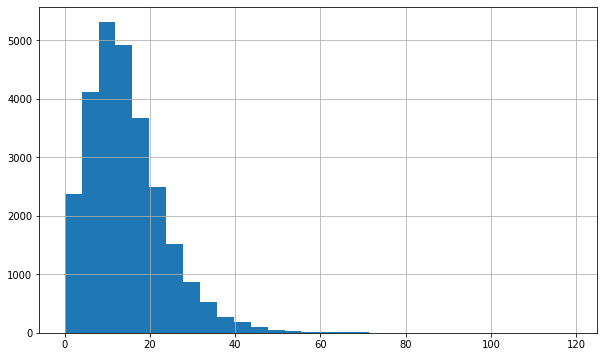

In [10]:
data['num_orders'].hist(bins=30, figsize=(10, 6))
plt.show()

Представленные данные судя по первичному анализу не требует правок, столбцы не требует перевода в другой формат или приведения в другой тип. Пропуски не были обнаружены.

Данные представлены за 6 месяцев, 2018-03-01 - 2018-08-31. 

In [11]:
data['datetime'] = pd.to_datetime(data['datetime'], errors='coerce')
data = data.set_index('datetime')
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


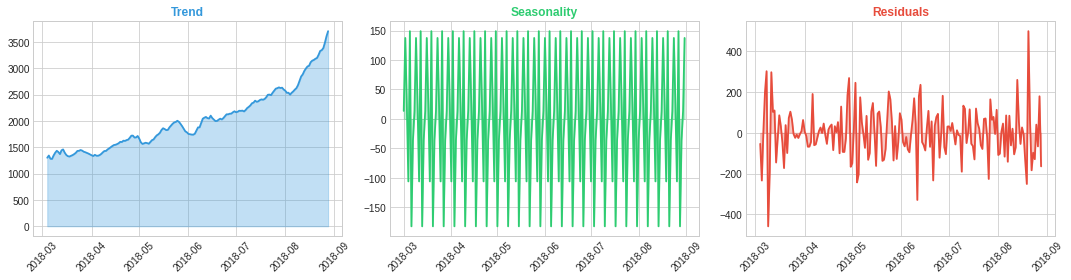

In [12]:
data_d = data.resample('1D').sum()
decomp = seasonal_decompose(data_d, model='additive', period=7)

plt.style.use('seaborn-whitegrid')
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
titles = ['Trend', 'Seasonality', 'Residuals']
colors = ['#3498db', '#2ecc71', '#e74c3c']  

for ax, series, title, color in zip(axes, 
                                    [decomp.trend, decomp.seasonal, decomp.resid], 
                                    titles, colors):
    ax.plot(series, color=color, linewidth=1.8)
    ax.fill_between(series.index, series, color=color, alpha=0.3) 
    ax.set_title(title, fontsize=12, fontweight='bold', color=color)
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

В результате проведения сезонной декомпозиции временного ряда были выделены три основные компоненты: тренд, сезонность и остатки (residuals).

- Трендовая компонента показывает выраженный рост исследуемого показателя в течение анализируемого периода.
Начиная с марта наблюдается плавное увеличение значений, что свидетельствует о положительной долгосрочной динамике — возможно, постепенном росте спроса, активности.

- Сезонная компонента демонстрирует чёткую цикличность с регулярными колебаниями примерно одинаковой амплитуды.
Вероятно, период сезонности составляет около 7 дней, что указывает на еженедельную закономерность — например, рост активности в определённые дни недели и спад в другие.

- Остаточная компонента колеблется случайным образом вокруг нуля без выраженной тенденции, что говорит об адекватности модели декомпозиции.
Основные закономерности временного ряда объясняются трендом и сезонностью, а остатки представляют собой случайные флуктуации (шум).

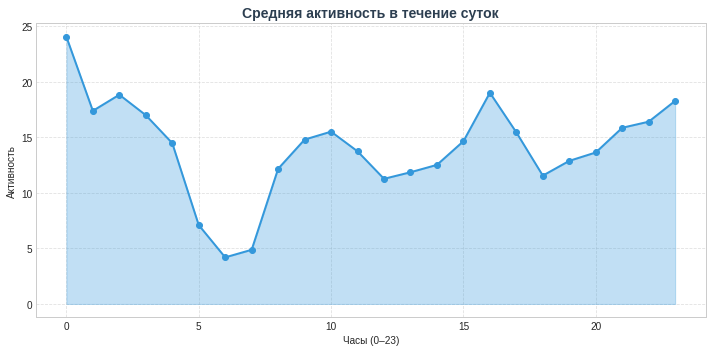

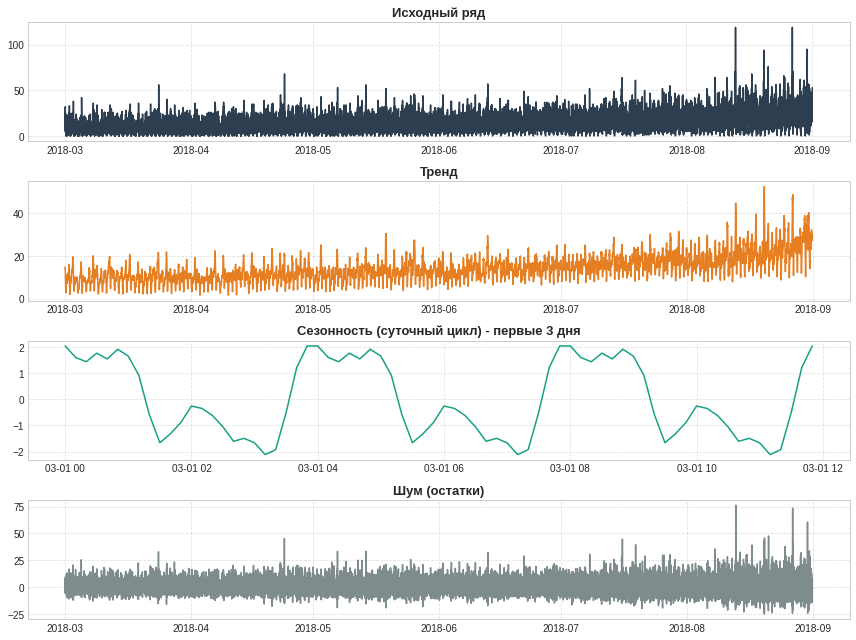

In [13]:
data['hour'] = data.index.hour
hourly_activity = data.groupby('hour').mean()

plt.figure(figsize=(10, 5))
plt.plot(hourly_activity.index, hourly_activity.iloc[:, 0], marker='o', color='#3498db', linewidth=2)
plt.fill_between(hourly_activity.index, hourly_activity.iloc[:, 0], color='#3498db', alpha=0.3)
plt.title('Средняя активность в течение суток', fontsize=14, fontweight='bold', color='#2c3e50')
plt.xlabel('Часы (0–23)')
plt.ylabel('Активность')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

data_hourly_sum = data.resample('1H').sum()
target_col = data.columns[0]

decomposition = seasonal_decompose(data[target_col], model='additive', period=24)

fig, axes = plt.subplots(4, 1, figsize=(12, 9), sharex=False) 

axes[0].plot(data[target_col], color='#2c3e50')
axes[0].set_title('Исходный ряд', fontsize=13, fontweight='bold')

axes[1].plot(decomposition.trend, color='#e67e22')
axes[1].set_title('Тренд', fontsize=13, fontweight='bold')


axes[2].plot(decomposition.seasonal.iloc[:72], color='#16a085')  # 72 часа = 3 дня
axes[2].set_title('Сезонность (суточный цикл) - первые 3 дня', fontsize=13, fontweight='bold')

axes[3].plot(decomposition.resid, color='#7f8c8d')
axes[3].set_title('Шум (остатки)', fontsize=13, fontweight='bold')

for ax in axes:
    ax.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

In [14]:
data.head()

,num_orders,hour
datetime,,
2018-03-01 00:00:00,9,0
2018-03-01 00:10:00,14,0
2018-03-01 00:20:00,28,0
2018-03-01 00:30:00,20,0
2018-03-01 00:40:00,32,0


- Пик заказ приходиться на 00:00 часов. Ранним утром (с 05:00 до 08:00) наблюдается спад заказов. В течении остального времени нет увеличения заказов. 
- Стоит отметить что данных не достаточно для определения годовой сезонности. Также стоит отметить что есть большое количество шума.

<b>Вывод</b>

- Исследовательский анализ показал что данные не требует удаления выбросов, также аномалий не было обнаружено. Представленные данные готовы для МО.

## Обучение

In [15]:
data = data.resample('1H').sum()

def make_features(data, max_lag, rolling_mean_size):
    data['hour'] = data.index.hour
    data['dayofweek'] = data.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)
    
    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()
    data.dropna(inplace=True)
    return data

make_features(data, 24, 4)

data.head()

,num_orders,hour,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,...,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-02 00:00:00,90,0,4,58.0,113.0,66.0,61.0,45.0,73.0,44.0,...,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,124.0,74.50
2018-03-02 01:00:00,120,1,4,90.0,58.0,113.0,66.0,61.0,45.0,73.0,...,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,81.75
2018-03-02 02:00:00,75,2,4,120.0,90.0,58.0,113.0,66.0,61.0,45.0,...,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,95.25
2018-03-02 03:00:00,64,3,4,75.0,120.0,90.0,58.0,113.0,66.0,61.0,...,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,85.75
2018-03-02 04:00:00,20,4,4,64.0,75.0,120.0,90.0,58.0,113.0,66.0,...,30.0,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,87.25


2018-03-02 00:00:00     90

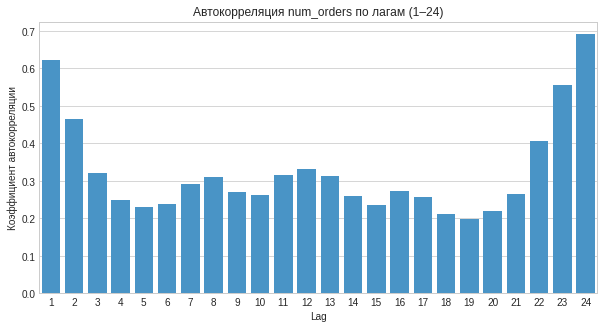

In [16]:
# выбираем лаги до 24
lags = 24
corrs = [data['num_orders'].autocorr(lag=i) for i in range(1, lags + 1)]

plt.figure(figsize=(10, 5))
sns.barplot(x=list(range(1, lags + 1)), y=corrs, color='#3498db')
plt.title('Автокорреляция num_orders по лагам (1–24)')
plt.xlabel('Lag')
plt.ylabel('Коэффициент автокорреляции')
plt.show()

In [17]:
data = data.drop(['lag_4', 'lag_5', 'lag_6', 'lag_7', 'lag_8', 'lag_9', 'lag_10', 
 'lag_11', 'lag_12', 'lag_13', 'lag_14', 'lag_15', 'lag_16', 
 'lag_17', 'lag_18', 'lag_19', 'lag_20', 'lag_21'], axis=1)

In [18]:
data.head()

,num_orders,hour,dayofweek,lag_1,lag_2,lag_3,lag_22,lag_23,lag_24,rolling_mean
datetime,,,,,,,,,,
2018-03-02 00:00:00,90,0,4,58.0,113.0,66.0,71.0,85.0,124.0,74.50
2018-03-02 01:00:00,120,1,4,90.0,58.0,113.0,66.0,71.0,85.0,81.75
2018-03-02 02:00:00,75,2,4,120.0,90.0,58.0,43.0,66.0,71.0,95.25
2018-03-02 03:00:00,64,3,4,75.0,120.0,90.0,6.0,43.0,66.0,85.75
2018-03-02 04:00:00,20,4,4,64.0,75.0,120.0,12.0,6.0,43.0,87.25


Автокорреляция показала что не все «Отстающие значения» коррелируют с целевым признаком, следовательно стоит некоторые из них удалить.

In [19]:
features = data.drop('num_orders', axis=1)
target = data['num_orders']
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.1, shuffle=False)

def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

In [20]:
model = LinearRegression()

param_search = {"fit_intercept": [True, False]}

tscv = TimeSeriesSplit(n_splits=3)
grid = GridSearchCV(estimator=model,
                    param_grid=param_search,
                    scoring='neg_root_mean_squared_error',
                    cv=tscv)

grid.fit(X_train, y_train)

best_lr = grid.best_estimator_
best_rmse = -grid.best_score_

start_fit = time.time()
best_lr.fit(X_train, y_train)
end_fit = time.time()

start_pred = time.time()
_ = best_lr.predict(X_train)
end_pred = time.time()

results = {}
results["LinearRegression"] = {
    "CV_RMSE": best_rmse,
    "Train_time": round(end_fit - start_fit, 4),
    "Pred_time": round(end_pred - start_pred, 6),
    "model": best_lr
}

In [21]:
hgb = HistGradientBoostingRegressor(
    max_depth=15,
    learning_rate=0.1,
    random_state=42
)

scores = cross_val_score(
    hgb, X_train, y_train,
    scoring='neg_root_mean_squared_error',
    cv=5, n_jobs=-1
)

start_fit = time.time()
hgb.fit(X_train, y_train)
end_fit = time.time()

start_pred = time.time()
_ = hgb.predict(X_train)
end_pred = time.time()

results["HistGradientBoosting"] = {
    "CV_RMSE": -scores.mean(),
    "Train_time": round(end_fit - start_fit, 4),
    "Pred_time": round(end_pred - start_pred, 6),
    "model": hgb
}

In [22]:
lgbm = LGBMRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=-1,
    random_state=42,
   )

scores = cross_val_score(
    lgbm, X_train, y_train,
    scoring='neg_root_mean_squared_error',
    cv=5, n_jobs=-1
)

start_fit = time.time()
lgbm.fit(X_train, y_train)
end_fit = time.time()

start_pred = time.time()
_ = lgbm.predict(X_train)
end_pred = time.time()

results["LightGBM"] = {
    "CV_RMSE": -scores.mean(),
    "Train_time": round(end_fit - start_fit, 4),
    "Pred_time": round(end_pred - start_pred, 6),
    "model": lgbm
}

In [23]:
best_model_name = min(results, key=lambda x: results[x]["CV_RMSE"])
best_model = results[best_model_name]["model"]

print("\n Результаты промежуточной оценки (CV):")
for name, res in results.items():
    print(f"{name}: RMSE={res['CV_RMSE']:.2f}, "
          f"Train={res['Train_time']} сек, "
          f"Pred={res['Pred_time']} сек")


 Результаты промежуточной оценки (CV):
LinearRegression: RMSE=28.02, Train=0.0047 сек, Pred=0.0716 сек
HistGradientBoosting: RMSE=24.28, Train=0.2858 сек, Pred=0.055388 сек
LightGBM: RMSE=24.46, Train=3.9971 сек, Pred=0.282951 сек


## Тестирование

In [24]:
y_pred = best_model.predict(X_test)
final_rmse = np.sqrt(((y_test - y_pred) ** 2).mean())

print(f"\n Лучшая модель: {best_model_name}")
print("Финальный тест RMSE:", round(final_rmse, 2))


 Лучшая модель: HistGradientBoosting
Финальный тест RMSE: 43.99


## Вывод


- Представленные данные были тщательно исследованы, был проведен анализ шумов, тренда и сезонности. Данные не требовали обработки и удаления аномальных значений, анализ показал что данные идут в хронологическом порядке, следовательно не требовали корректировки.

- Из-за ограниченности данных (всего 6 месяцев) определить годовую сезонность не представляется возможным.

- Было выявлено что в некоторые дни недели заказы такси были больше, это было учтено при генерации признаков для МО. Аналогичная зависимость была и в рамках одного дня т.е. в определенное время дня заказов было больше.

- При добавленни признаков lag features были выявлены что некоторые конфигурации "отстающих значений" коррелировали с целевым признаком больше к примеру lag_1, lag_2, lag_23, lag_24. Для устранения неинформативных признаков и увеличения точности модели было решено оставить только самые "полезные признаки".    

<b>Результаты машинного обучения</b>
- Были выбраны три модели для задачи МО, это LinearRegression, HistGradientBoosting и LightGBM. 

- Лучшей из них оказалась HistGradientBoosting с показателем RMSE на тренировочных данных - 24.28 и тестовой 43.99

- Разница между тестовыми и тренировочными данными обусловлена двумя факторами, это: 
- 1) недостаток данных за весь календарный год.

- 2) увеличением количества заказов в конце представленных данных. Если в Марте было 1300-1450 заказов, то в Августе количество заказов было от 2500 до 3800. 